# Dataset SCIA
Registrazione delle misure recuperate dal database SCIA.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [1]:
dataset_id <- "SCIA"
state <- "Italia"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)


source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
ita_boundaries <- load.italian_boundaries("state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [3]:
c(full_stations_metadata, daily_data) %<-% (load_daily_data.scia() |> prepare_daily_data(first_date, last_date))
c(stations_metadata, stations_extra_metadata) %<-% split_station_metadata(full_stations_metadata)


In [5]:
checkpoint_database(list("meta" = stations_metadata, "data" = daily_data), dataset_id, "raw")
write_extra_metadata(stations_extra_metadata, dataset_id, provisional = FALSE)


## Quality check 1
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [6]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = FALSE)

checkpoint_database(qc_database, dataset_id, "qc1")


Warning message:
"The resulting dataset has an unusually small number of elements wrt to the original"


## Analisi disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

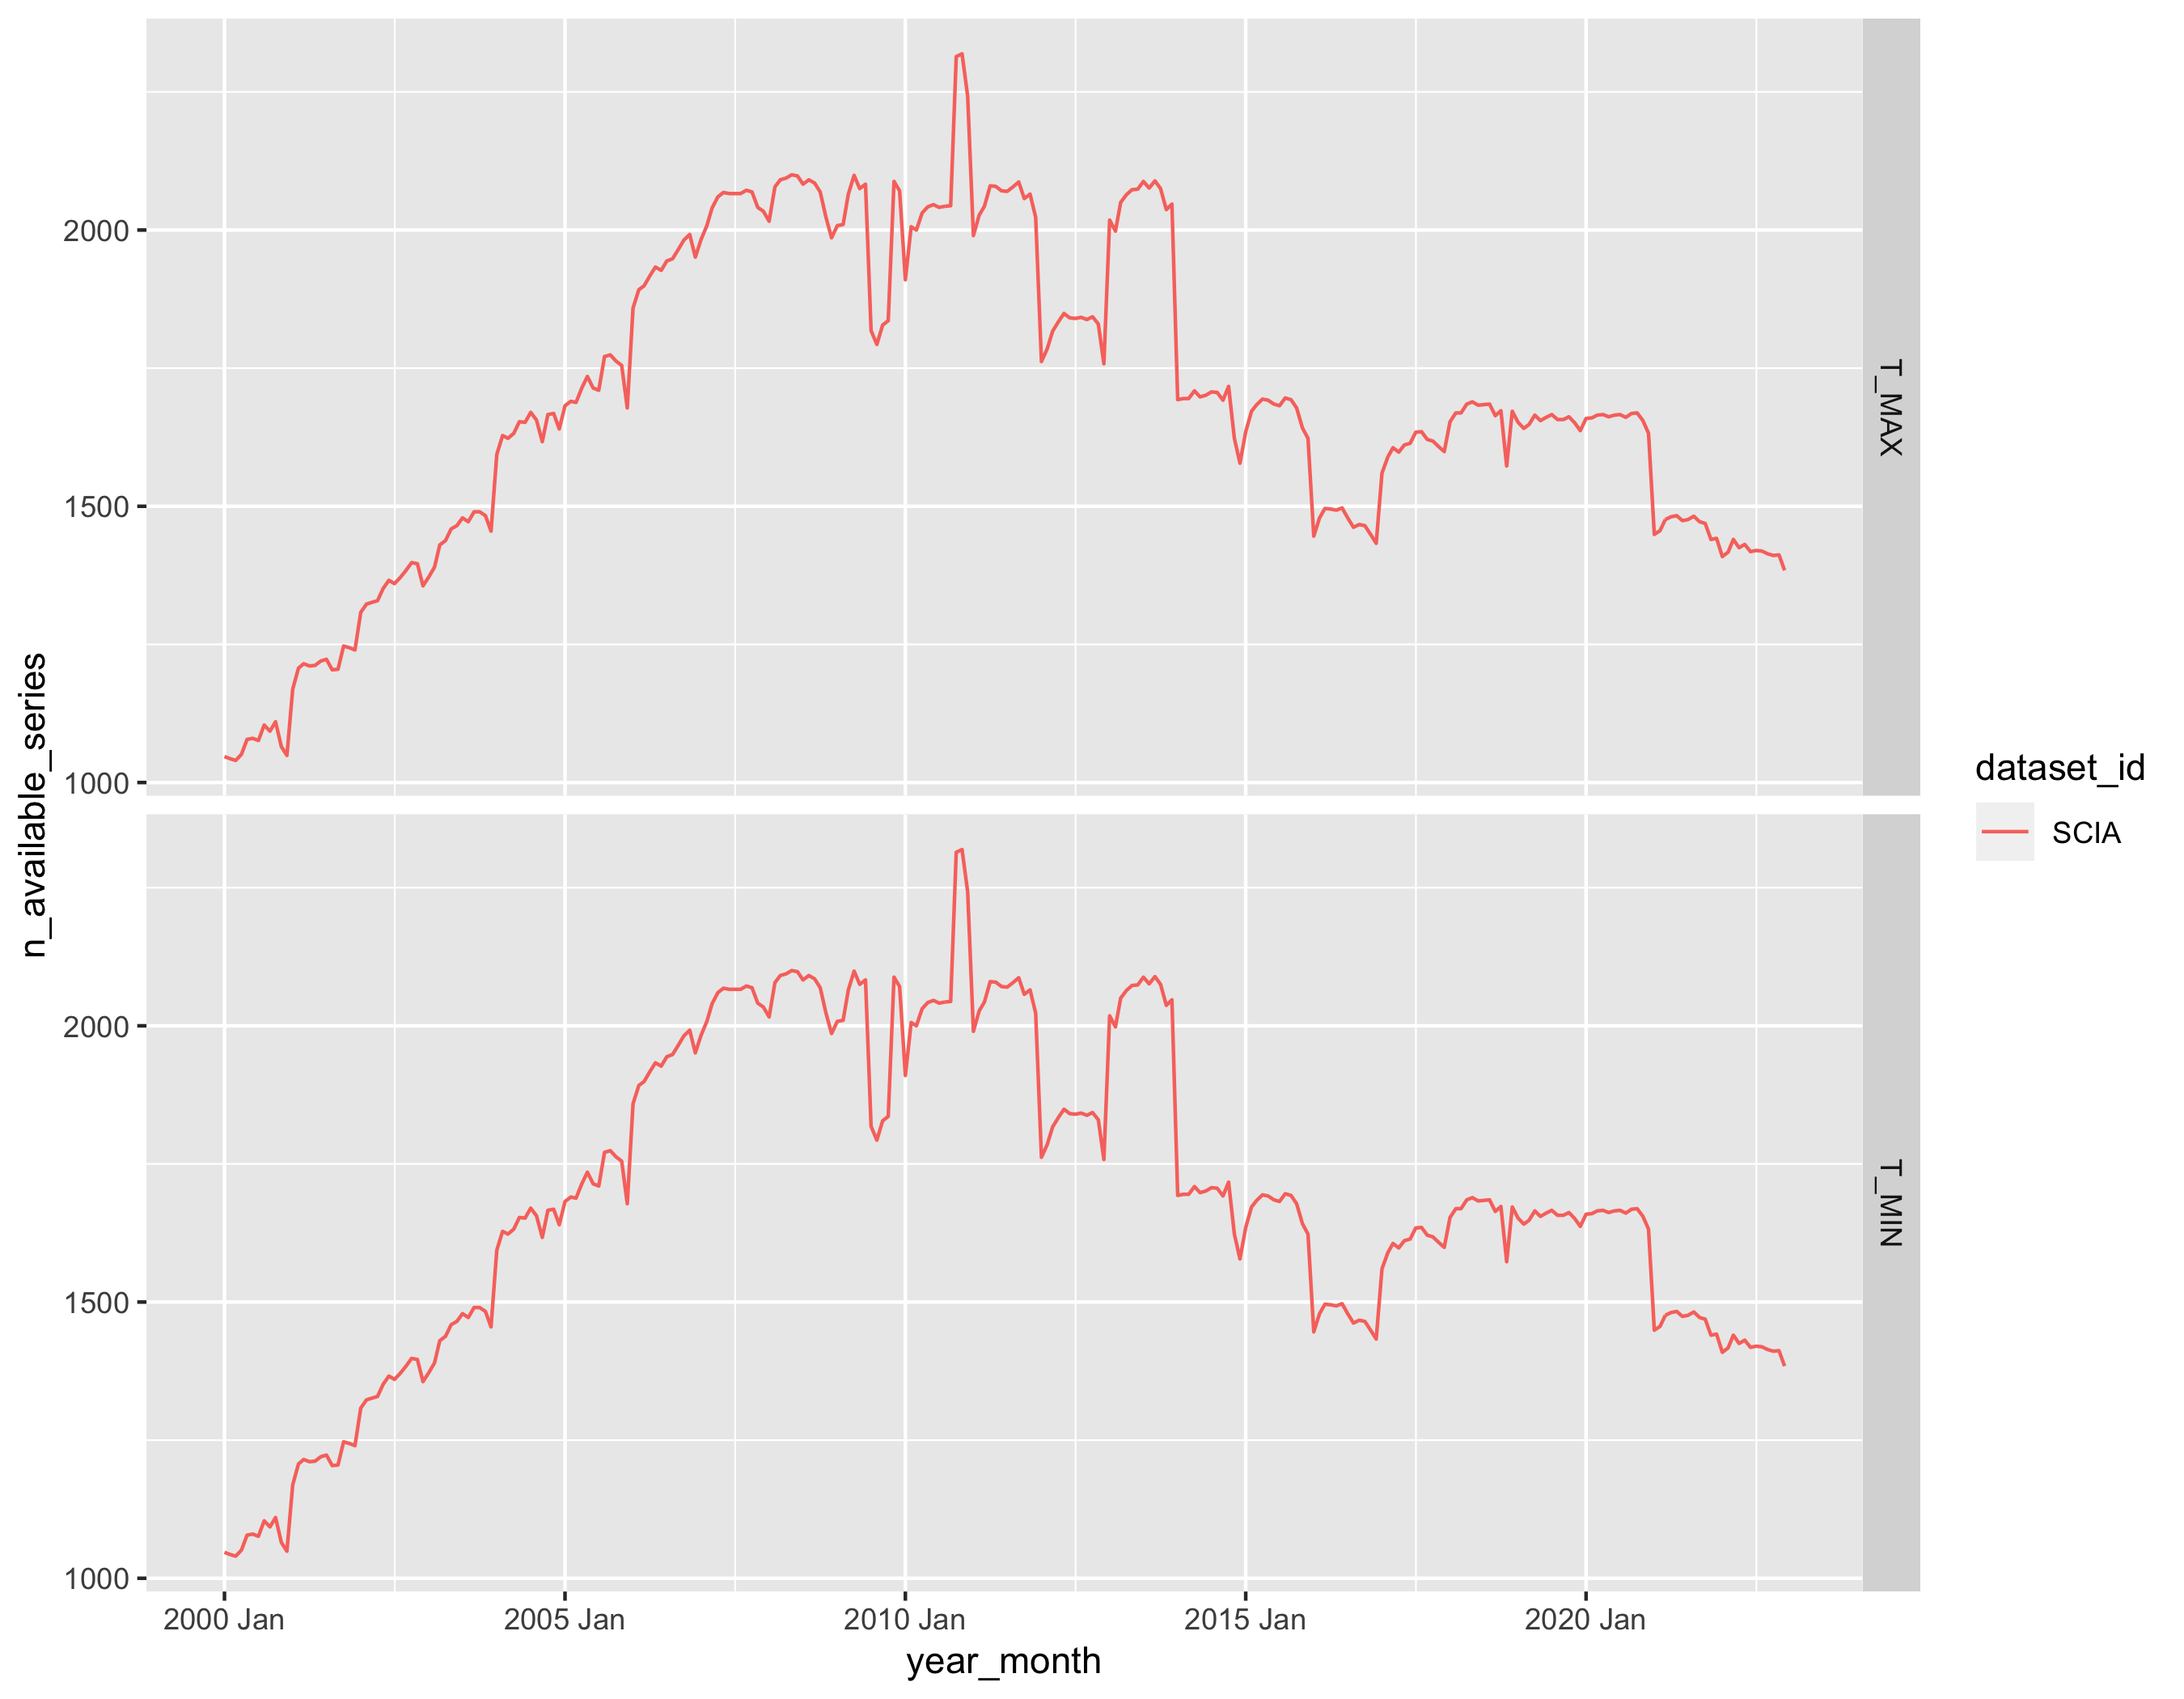

In [7]:
qc_database <- open_checkpoint(dataset_id, "qc1")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database, start_date = first_date, end_date = last_date)
p

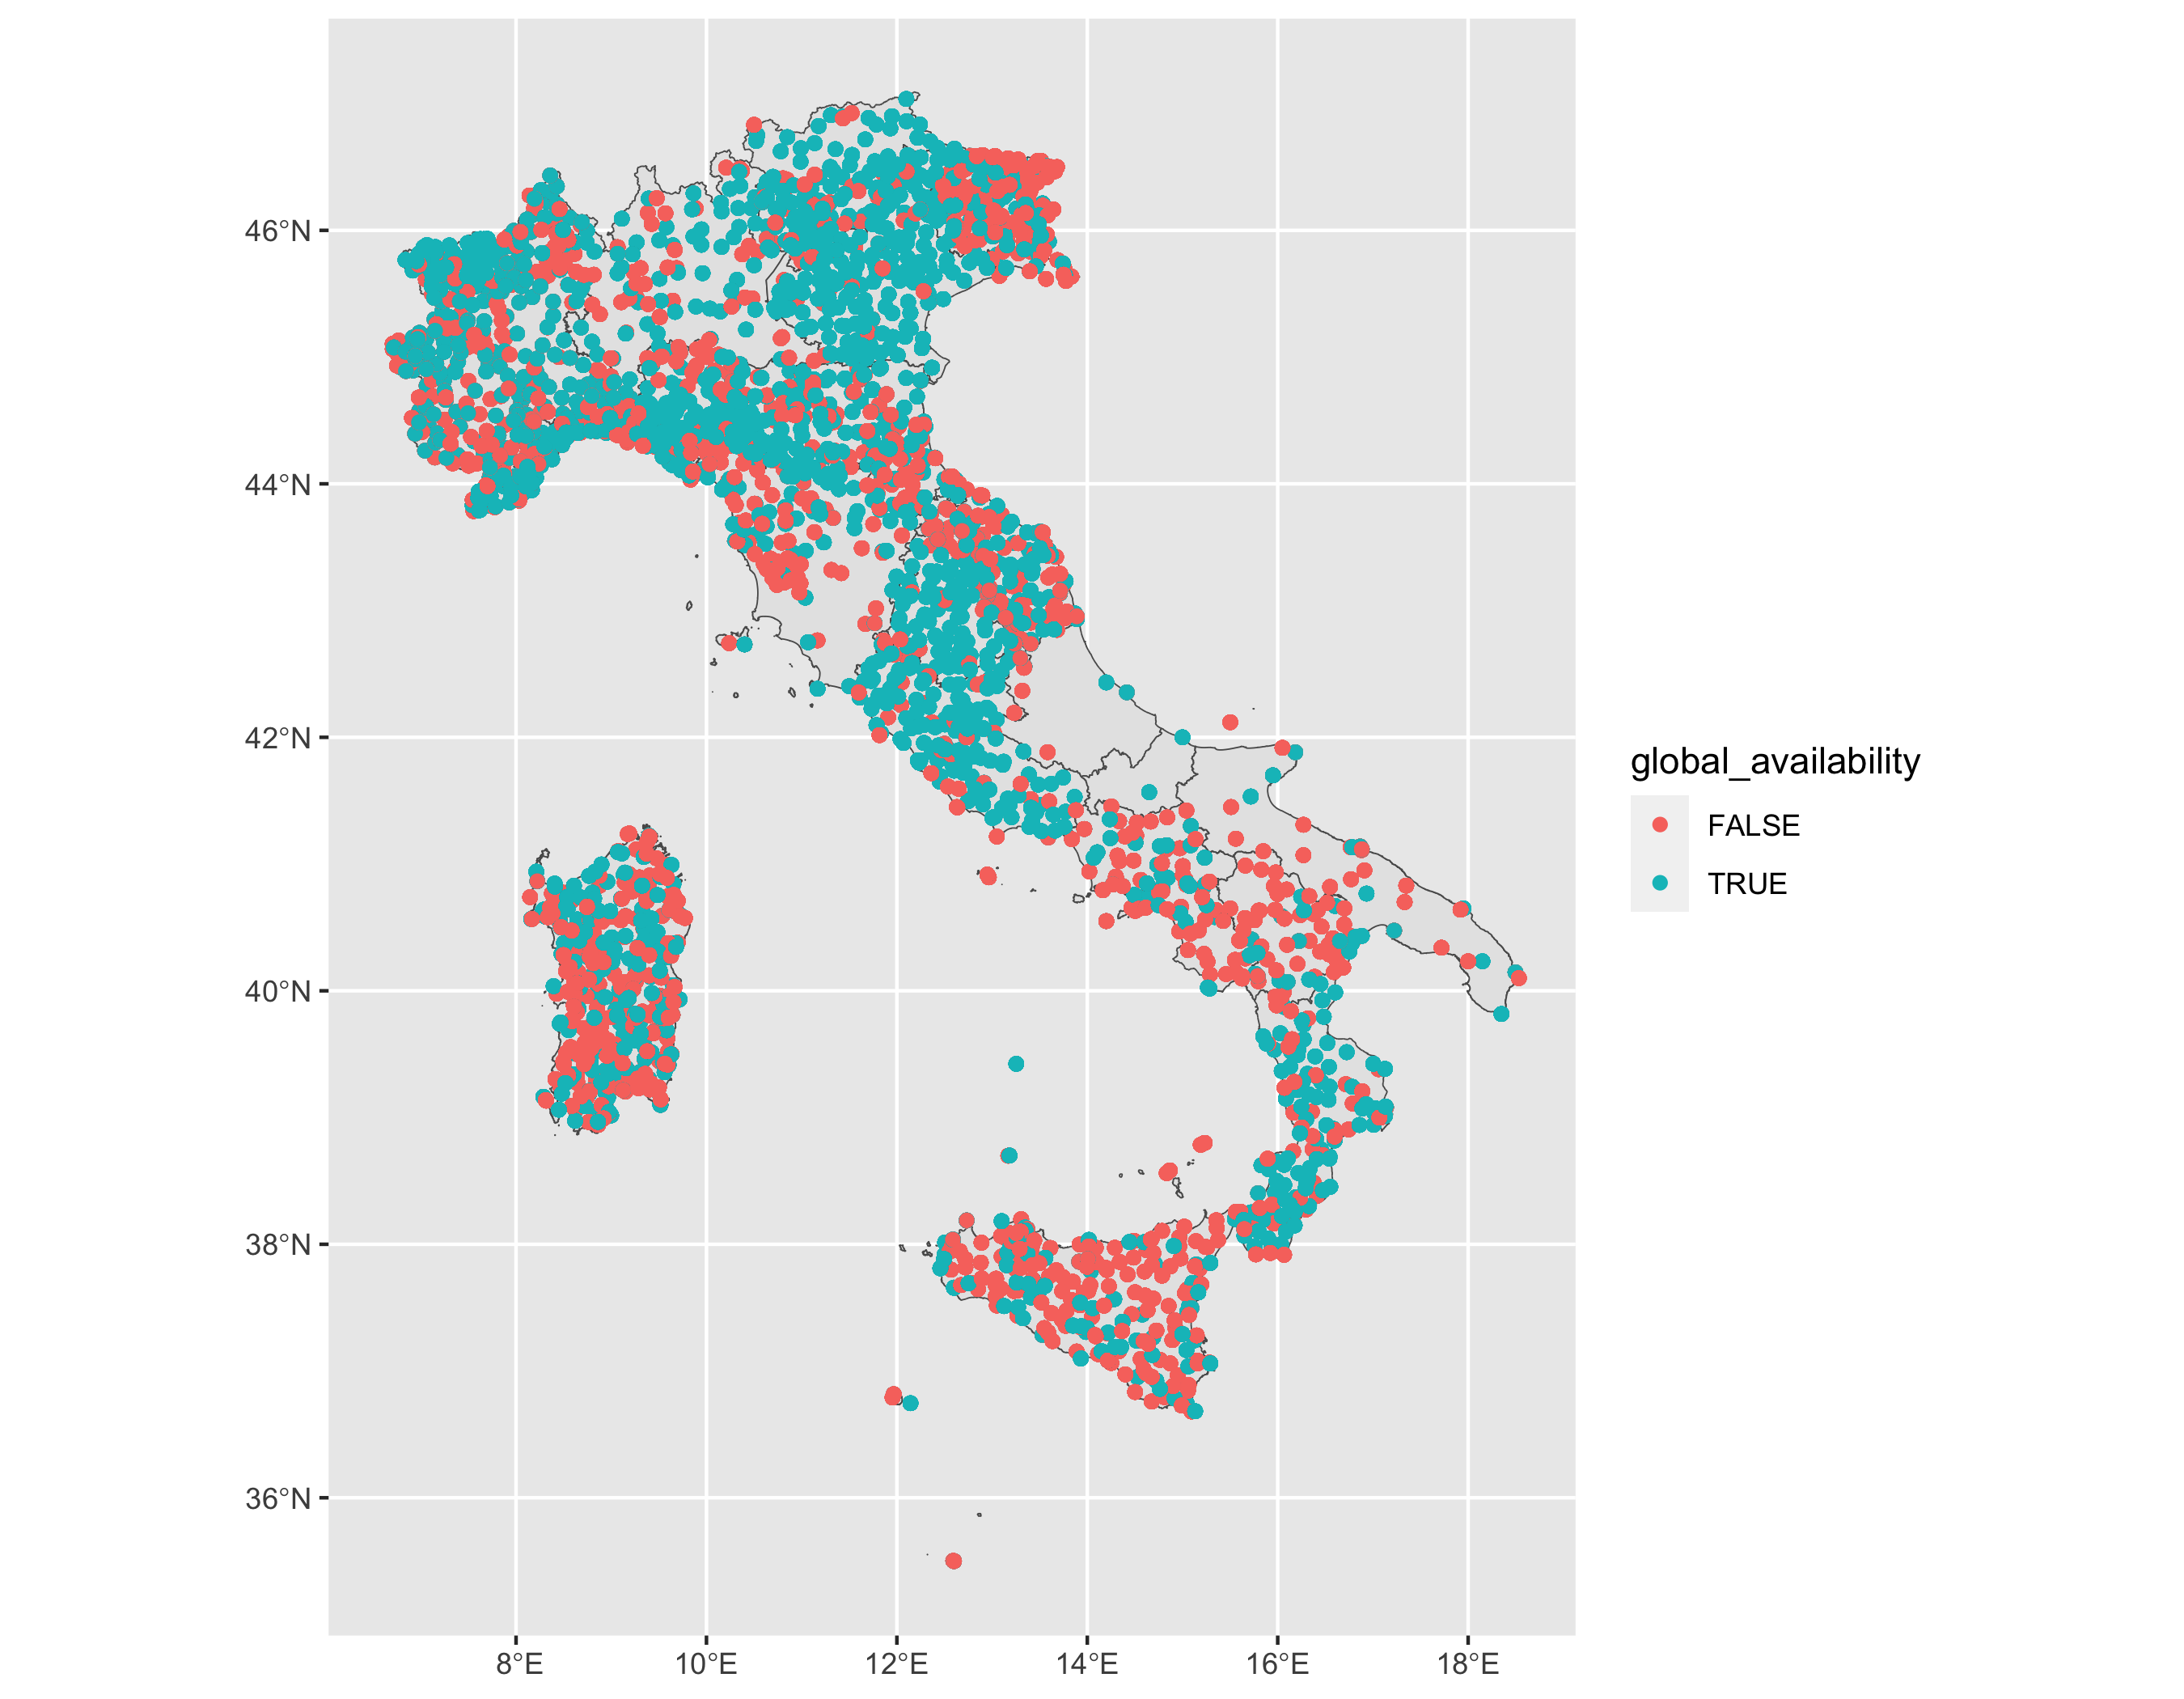

In [8]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail |> filter(dataset_id == !!dataset_id), qc_database$meta, ita_boundaries)
p


## Merging
Gap-filling con altri dataset.
Registrazione dell'esito.